# Predicting Player Engagement: A Regression Analysis of Age and Experience on Total Session Time
## DSCI 100 007 - Group 9 Final Report  
`Members:` Alana Duan, Eva Jiang, Lucia Song, and Leo Wang  
`Date:` April 5th, 2025

# Introduction

Understanding what drives player engagement is essential for designing games that retain users and provide personalized experiences. In collaboration with the Pacific Laboratory for Artificial Intelligence (PLAI), a UBC Computer Science research group focused on player behavior in game-based environments, we gained access to a unique dataset collected from a custom Minecraft server designed to engage youth in scientific exploration (Science, 2018). One widely used measure of engagement is **total session time**, which reflects how long a player actively interacts with the game. Game developers and researchers benefit from knowing which user attributes predict longer play times.

In this project, we aim to answer the following question:

**Can age and experience level predict total played time per player?**

To explore this, we use data provided by a UBC Computer Science research group studying player behavior in a custom Minecraft server environment. The data consist of two files:  
- `players.csv` contains demographic and background information for each unique player, including variables such as age and self-reported experience level.  
- `sessions.csv` records individual play sessions, including session duration and player identifiers.

We merge these datasets using a unique identifier and compute the total session time for each player by aggregating their individual session durations. After performing data cleaning and preprocessing to remove missing or inconsistent entries, we apply a  regression model to analyze how age and experience level relate to total play time. The model is evaluated using metrics such as R-squared and root mean square error (RMSE), and the coefficients are interpreted to determine the strength and direction of each predictor's effect.

The player data used in this project was provided by the Pacific Laboratory for Artificial Intelligence (PLAI), a UBC Computer Science research group focused on game-based learning environments (Home Page. Pacific Laboratory for Artificial Intelligence, 2024). The dataset was collected from a custom Minecraft server built and maintained by UBC researchers to support youth engagement in science (Science, U. "How an Imperfect Diamond Led to a Perfect Scientific Discovery", 2018).

In [1]:
# LOAD PACKAGES
library(tidyverse)
library(tidymodels)
library(janitor) # for clean_names
library(repr)
library(infer)
library(cowplot)
library(recipes)

options(repr.matrix.max.rows = 6,
        repr.plot.width = 10,
        repr.plot.height = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Methods & Results

This section provides a step-by-step walkthrough of our analysis pipeline, starting from loading the dataset and cleaning the data, followed by exploratory data analysis, model training using linear and KNN regression, prediction visualization, and model evaluation.

### Loads & cleans data

In [2]:
# Load players data
players <- url("https://raw.githubusercontent.com/arevaura/dsci-100-2024w2-group-9/refs/heads/main/data/players.csv") |>
    read_csv() |>
    clean_names()
head(players, n=5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


In [3]:
# Load sessions data
sessions_raw <- url("https://raw.githubusercontent.com/arevaura/dsci-100-2024w2-group-9/refs/heads/main/data/sessions.csv") |>
    read_csv() |>
    clean_names()
head(sessions_raw, n=5)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12


### General Visualizations of Player Data （Creates visualization for exploratiry data analysis）

In [4]:
peak_age <- players |>
    select(age) |>
    count(age) |>
    slice_max(n) |>
    pull(age)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


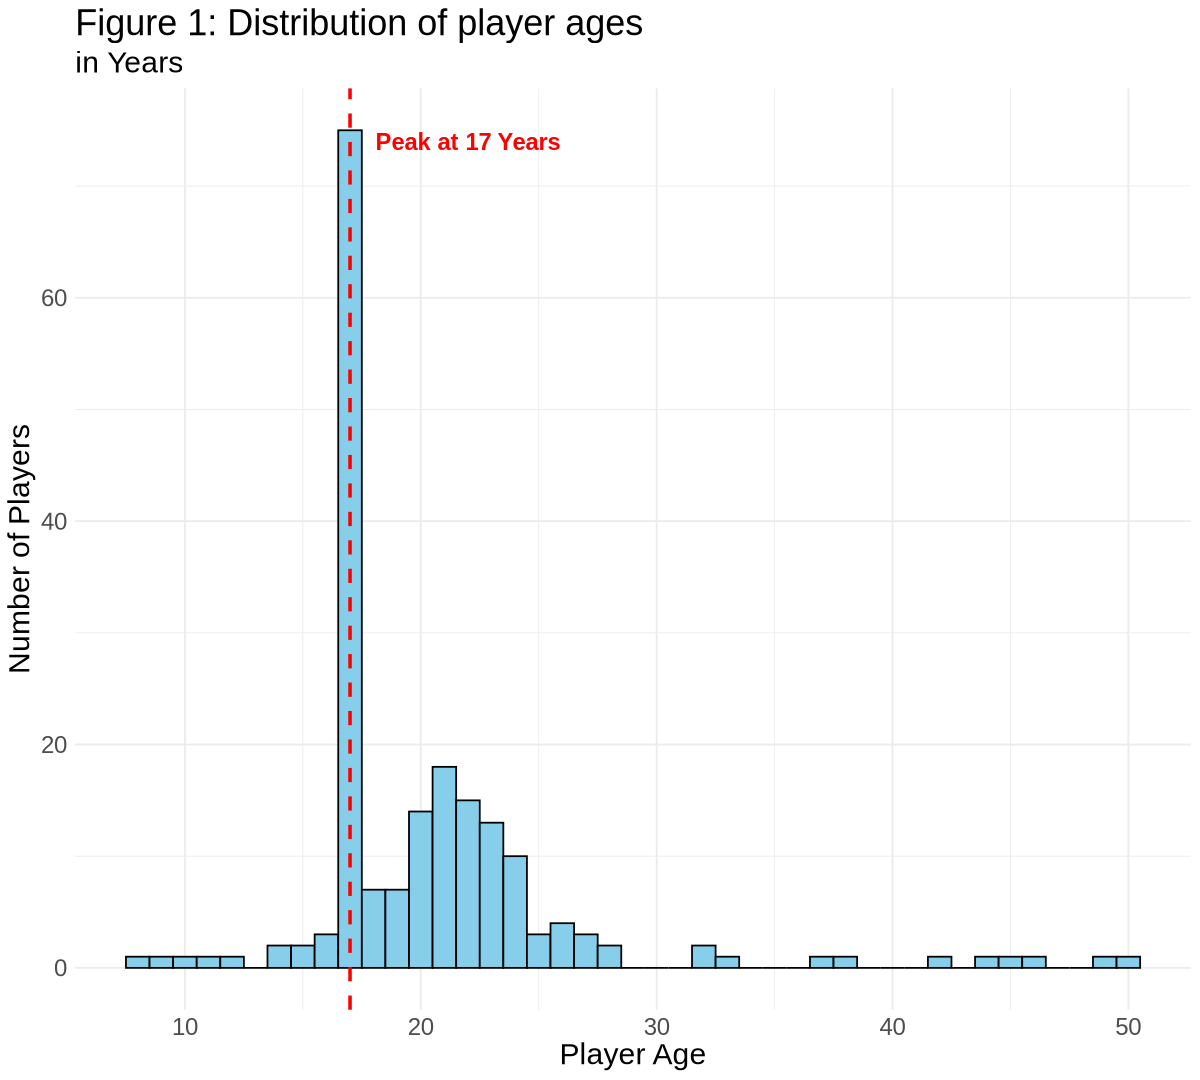

In [5]:
age_plot <- players |> 
    ggplot(aes(x = age)) +
        geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
        geom_vline(xintercept = peak_age, color = "red", linetype = "dashed", size = 1) +
        annotate(
            "text", 
            x = peak_age + 5, 
            y = players |>
                select(age) |>
                count(age) |>
                slice_max(n) |>
                pull(n) - 1, 
            label = paste("Peak at", round(peak_age, 1), "Years"), 
            color = "red", 
            size = 5,
            fontface = "bold") +
        labs(x = "Player Age", 
             y = "Number of Players", 
             title = "Figure 1: Distribution of player ages",
             subtitle = "in Years") +
        theme_minimal() +
        theme(text = element_text(size = 18))
options(repr.plot.width = 10, repr.plot.height = 9)
age_plot

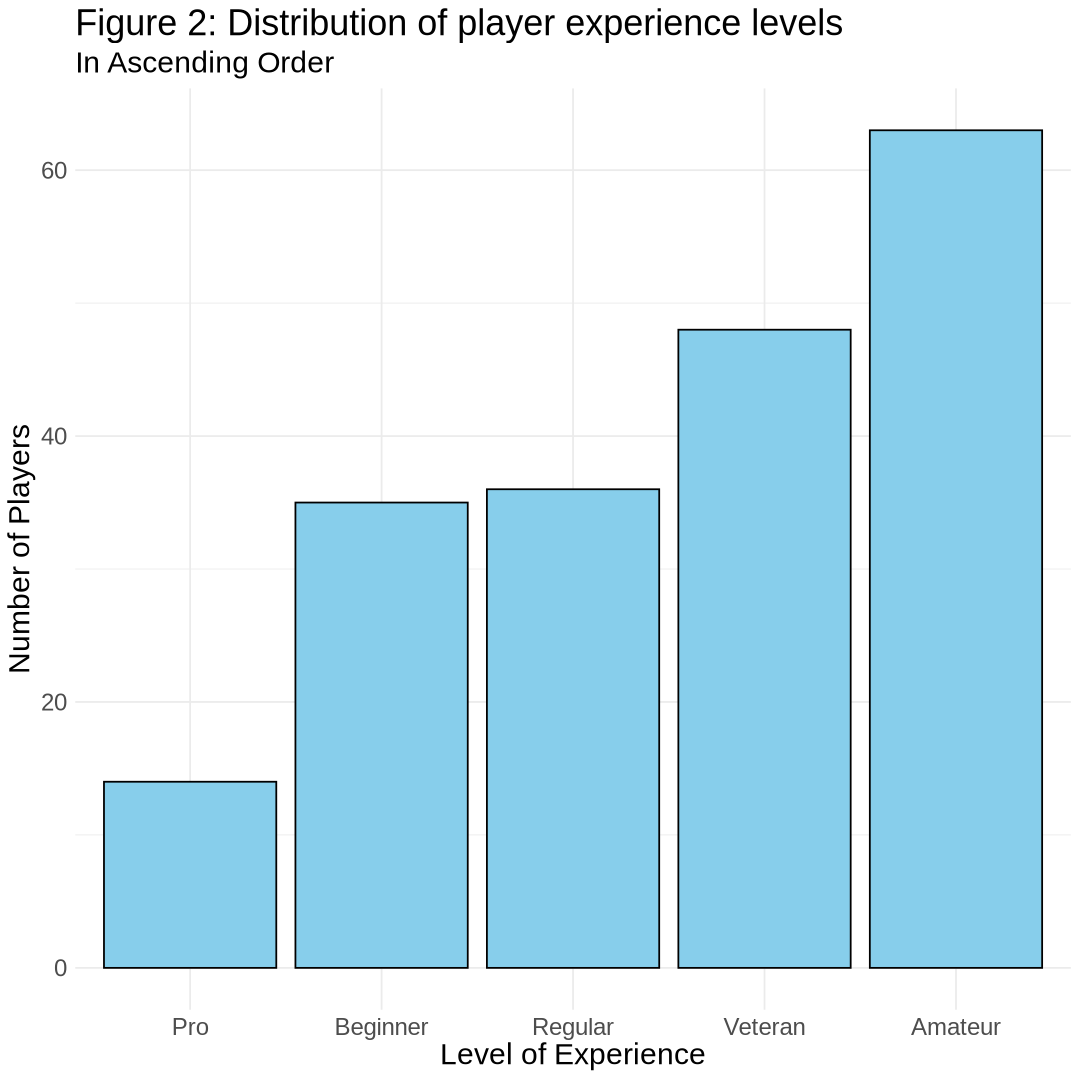

In [6]:
experience_level_plot <- players |>
    count(experience) |>
    ggplot(aes(x = fct_reorder(experience, n), y=n)) +
        geom_bar(stat="identity", fill = "skyblue", color = "black") +
        labs(x = "Level of Experience", 
             y = "Number of Players", 
             title = "Figure 2: Distribution of player experience levels",
             subtitle = "In Ascending Order") + 
        theme_minimal() +
        theme(text = element_text(size = 18))
options(repr.plot.width = 9)
experience_level_plot

### Aggregation of Datasets （Wrangles and cleans the data）

In [7]:
head(sessions_raw, n=3)

hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12


In [8]:
# Format the datetimes in sessions.csv to have a more useful data type
sessions_dttm <- sessions_raw |>
    mutate(
        start_time = dmy_hm(start_time),
        end_time = dmy_hm(end_time)
    ) |>
    select(-starts_with("original")) # removes original datetime numbers

In [9]:
# Add session duration columns to the dataframe
sessions <- sessions_dttm |>
    mutate(
        duration_minutes = as.numeric(end_time - start_time, units="mins", na.rm = TRUE),
        duration_hours = as.numeric(end_time - start_time, units="hours", na.rm = TRUE)
    )
head(sessions, n=3)

hashed_email,start_time,end_time,duration_minutes,duration_hours
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,12,0.2000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,13,0.2166667
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,23,0.3833333


In [10]:
# Combine dataframes
combined_data <- left_join(players, sessions, by = "hashed_email")
head(combined_data, n=3)

experience,subscribe,hashed_email,played_hours,name,gender,age,start_time,end_time,duration_minutes,duration_hours
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,74,1.2333333
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,7,0.1166667
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,44,0.7333333


### Performs summary of the dataset

In [11]:
# Select interesting variables
data <- combined_data |>
    group_by(hashed_email) |>
    summarize(age = first(age),
             experience = first(experience),
             total_playtime_minutes = sum(duration_minutes, na.rm = TRUE)) |>
    select(-hashed_email)
data <- filter(data, total_playtime_minutes > 0)
data

age,experience,total_playtime_minutes
<dbl>,<chr>,<dbl>
20,Regular,106
21,Pro,30
17,Beginner,11
⋮,⋮,⋮
23,Amateur,4795
17,Amateur,9
20,Beginner,72


### Creates a visualization of the analysis - Linear Regression Model (Tiffany Timbers, 2024)

In [12]:
# Create training and testing datasets
set.seed(2025)

data_split <- initial_split(data, prop = 0.6, strata = total_playtime_minutes)
data_training <- training(data_split)
data_testing <- testing(data_split)

In [13]:
# Create specification and recipe
set.seed(2025)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

data_recipe <- recipe(total_playtime_minutes ~ ., data = data_training)

print(lm_spec)
print(data_recipe)

Linear Regression Model Specification (regression)

Computational engine: lm 





── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



In [14]:
# Create workflow and fit
set.seed(2025)

data_fit <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(lm_spec) |>
    fit(data = data_training)
data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
       (Intercept)                 age  experienceBeginner       experiencePro  
           1414.02              -28.67             -699.55             -609.89  
 experienceRegular   experienceVeteran  
            945.11             -691.51  


In [15]:
# Calculate RMSE

data_test_results <- data_fit |>
    predict(data_training) |>
    bind_cols(data_training) |>
    metrics(truth = total_playtime_minutes, estimate = .pred)                    
data_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.871959e+03
rsq,standard,7.968384e-02
mae,standard,9.322633e+02


In [16]:
data_predict <- data_fit |>
    predict(data_training) |>
    bind_cols(data_training)
data_predict

.pred,age,experience,total_playtime_minutes
<dbl>,<dbl>,<chr>,<dbl>
227.1098,17,Beginner,11
811.9875,21,Amateur,5
926.6602,17,Amateur,7
⋮,⋮,⋮,⋮
546.1205,9,Pro,2019
955.3284,16,Amateur,9947
754.6511,23,Amateur,4795


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


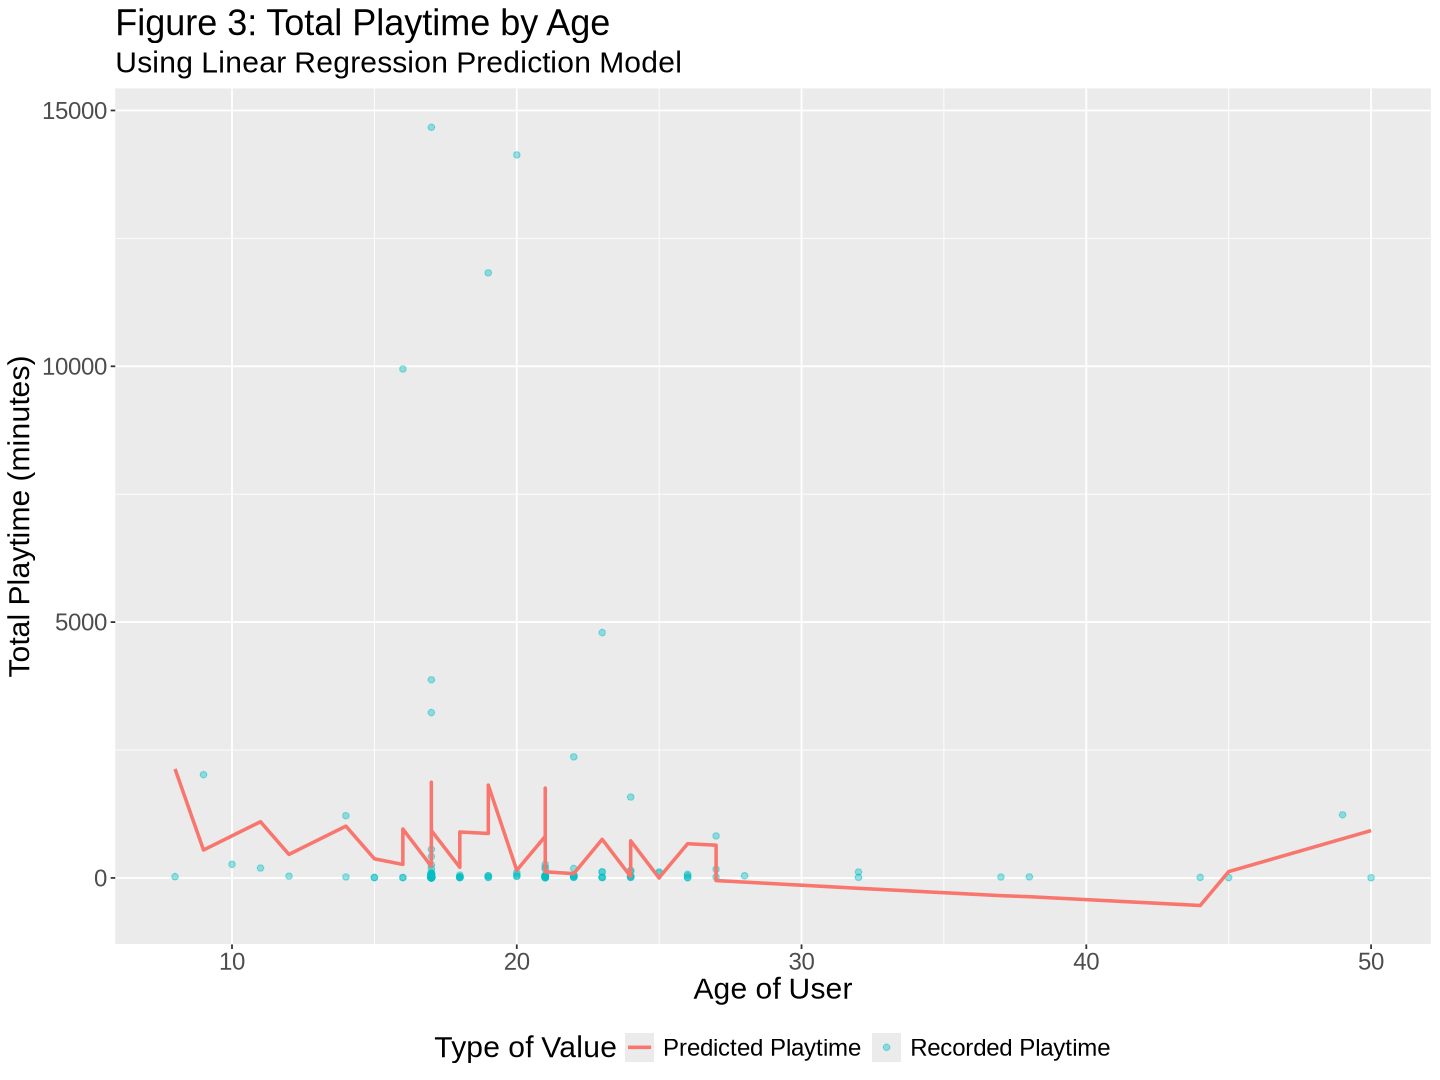

In [54]:
plot_final <- ggplot(data) +
    geom_point(alpha = 0.4, 
               aes(x = age, 
                   y = total_playtime_minutes, 
                   color = "Recorded Playtime")) +
    geom_line(data = data_predict,
              aes(x = age, 
                  y = .pred, 
                  color = "Predicted Playtime"),
              linewidth = 1) +
    labs(x = "Age of User",
         y = "Total Playtime (minutes)",
         color = "Type of Value",
         title = "Figure 3: Total Playtime by Age",
         subtitle = "Using Linear Regression Prediction Model")  +
         theme(text = element_text(size = 18),
               legend.position = "bottom") +
     scale_y_continuous()
options(repr.plot.width = 12)
plot_final

### Creates a visualization of the analysis - KNN Regression Model (Tiffany Timbers, 2024)

In [18]:
set.seed(2025)

data_split <- initial_split(data, prop = 0.6, strata = total_playtime_minutes)
data_training <- training(data_split)
data_testing <- testing(data_split)

In [19]:
data_recipe <- recipe(total_playtime_minutes ~ age + experience, data = data_training)|>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("regression")

data_spec

data_wkflw <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(data_spec)

data_wkflw

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


In [20]:
data_fit <- fit(data_wkflw, data = data_training)

predictions <- data_fit |>
    predict(new_data = data_testing) |>
    bind_cols(data_testing)

result <- metrics(predictions, truth = total_playtime_minutes, estimate = .pred)
result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.654225e+03
rsq,standard,8.928274e-02
mae,standard,1.166569e+03


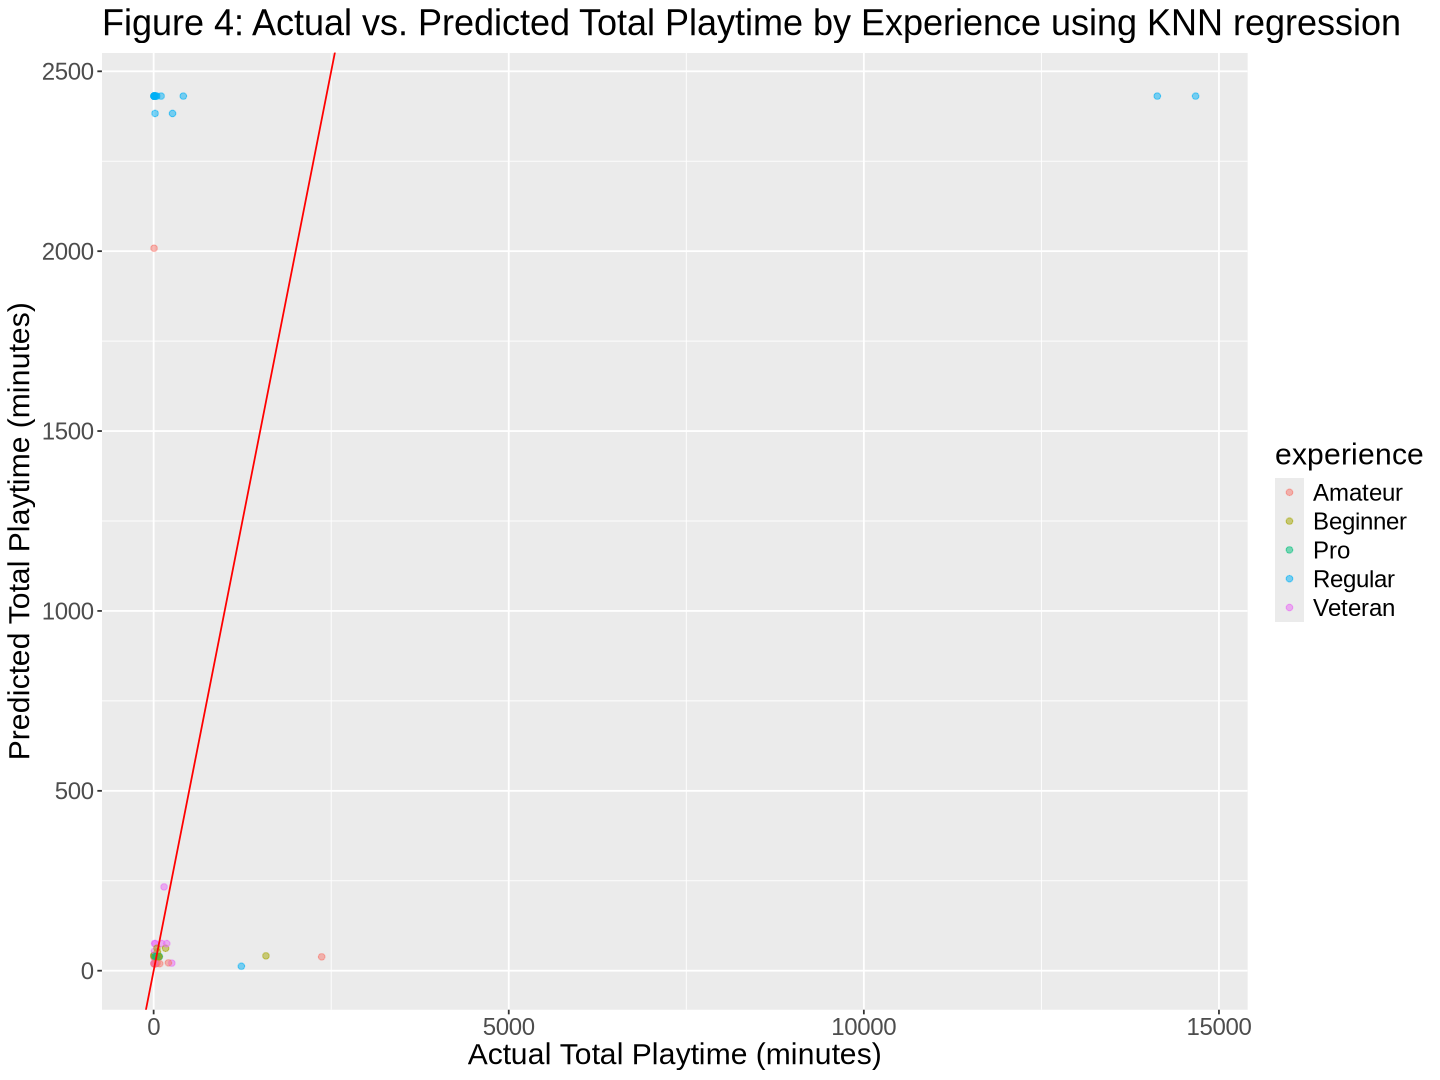

In [21]:
options(repr.plot.width = 12)
data_plot <- predictions|>
    ggplot(aes(x = total_playtime_minutes, y = .pred, color = experience)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1, intercept = 0, linetype = "solid", color = "red") +
    labs(x = "Actual Total Playtime (minutes)",
         y = "Predicted Total Playtime (minutes)",
         title = "Figure 4: Actual vs. Predicted Total Playtime by Experience using KNN regression") +
         theme(text = element_text(size = 18))
data_plot

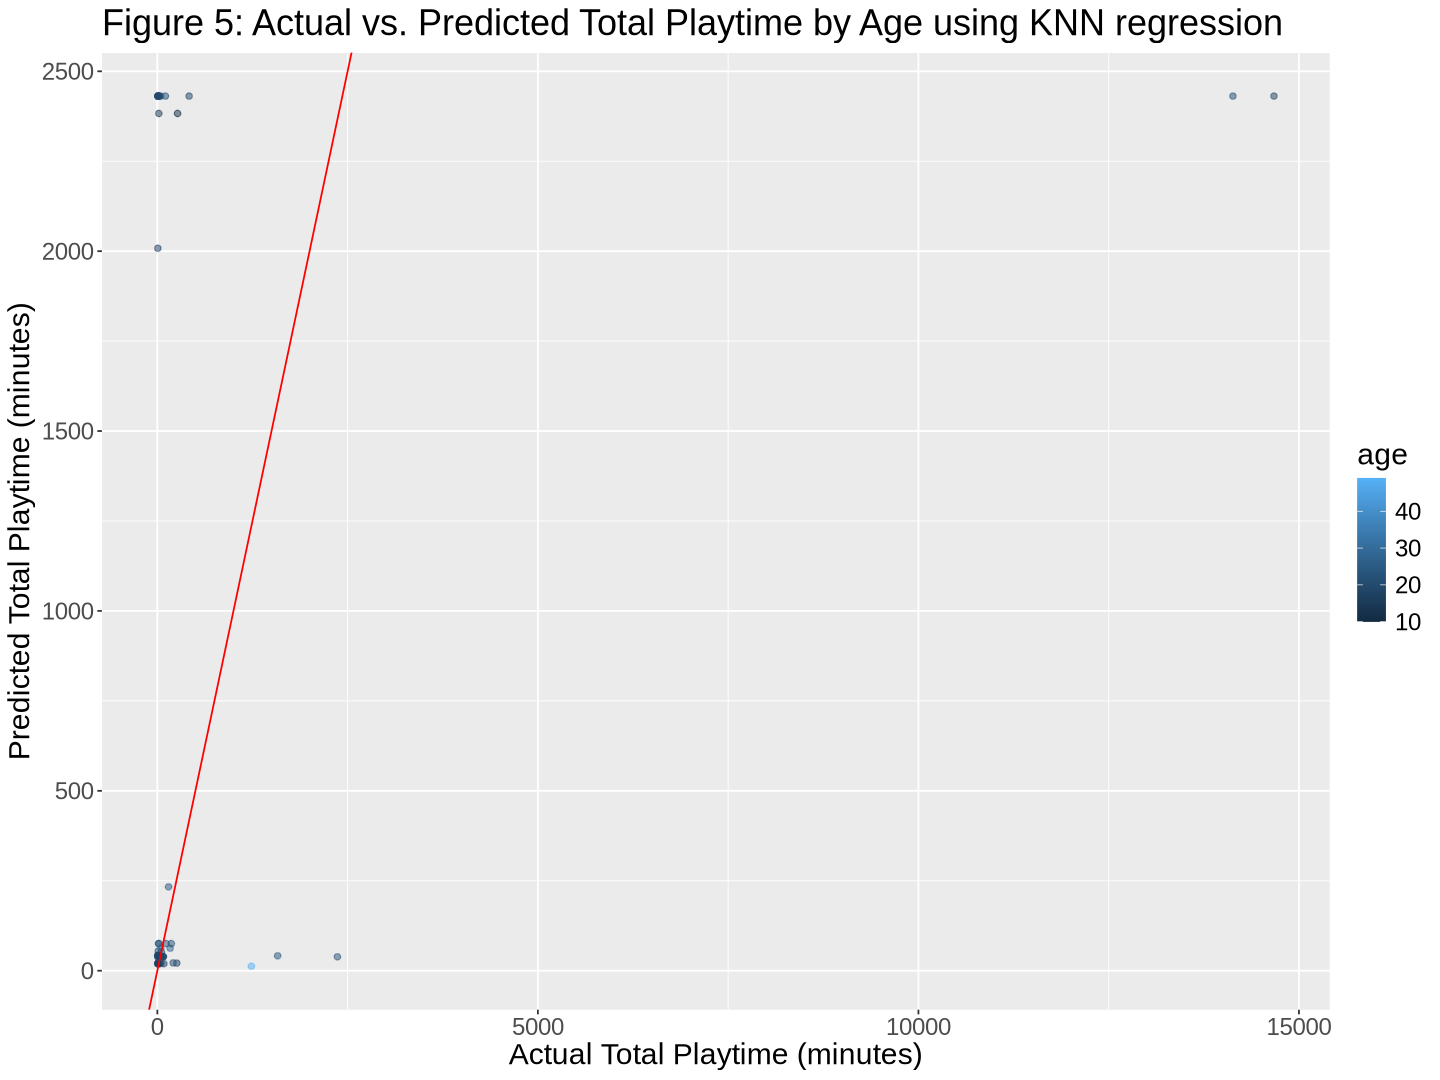

In [22]:
options(repr.plot.width = 12)
data_plot_age <- predictions|>
    ggplot(aes(x = total_playtime_minutes, y = .pred, color = age)) +
    geom_point(alpha = 0.5) +
    geom_abline(slope = 1, intercept = 0, linetype = "solid", color = "red") +
    labs(x = "Actual Total Playtime (minutes)",
         y = "Predicted Total Playtime (minutes)",
         title = "Figure 5: Actual vs. Predicted Total Playtime by Age using KNN regression") +
         theme(text = element_text(size = 18))
data_plot_age

# Discussion

**What We Found**

Our analysis explored whether age and experience level could predict the total session time per player, using data from the UBC Minecraft server. We first tried a linear regression model with total playtime as the response variable; however, the results from this revealed that the data did not have a linear trend. Due to this, we then chose to do KNN regression instead. The model revealed that experience level was the most significant  predictor as it clearly revealed that level “Regular” had significantly longer total play sessions compared to other experience levels. This is seen in the visualization as an isolated tight cluster of “Regular” players are seen within the 2250-2500 minutes range. Age had a weak positive association with total playtime shown by the visualization as it only shows the majority of plots being dark blue representing the 10-30 age range but no trend in distribution of playtime due to age is shown. Breaking down the results from the linear model, the RMSE shows that the predictions were off by ~1872 minutes (≈ 31 hours), R² shows it only accounts for ~7.97% of the variance in total playtime and MAE of ~932 minutes (≈ 15.5 hours) average absolute error. These interesting results are due to the linear models assuming a straight-line relationship between predictor and outcome, causing underfitting, especially as the data is not linear.  Looking at the KNN model, the RMSE shows our predictions are off by ~2654 minutes (≈ 44 hours) which is heavily influenced by outliers. The R² (rsq), shows that our model only accounts for ~8.9% of the variance in total playtime and the MAE reveals the average error is ~1167 minutes (≈ 19.4 hours), also showing lack of precision. This can be explained by how KNN works, as it finds the nearest neighbours based on the predictors, but a problem arises in this case, such that two players who are the same age could have very different playing behaviors, making the even neighbours bad predictors. These numbers suggest that while the model captures trends especially from experience level, there is a significant lack of accuracy and precision in the results mainly due to the weak predictive power of age in relation to total playtime. Ultimately, the slightly greater accuracy and precision with the linear model using only experience level, suggests that experience level is a more reliable predictor of total playtime than age; however, KNN captured more variance.

**Did This Match Expectations?**

We expected that more experienced levels such as “Veteran” and “Regular” would spend more time in the game, and this was strongly confirmed. It makes sense as players who are more familiar with the game enjoy it more and are probably more committed to longer sessions. However, we expected age to play a larger role, as we assumed younger players, especially age groups near the peak of distribution of total players which was 17 years old, would have more time or interest in playing the game. The results went against our expectations showing that age was a weak predictor suggesting that total playtime goes beyond just basic traits. For example, it might be better explained by aspects such as psychological or behavioral patterns not captured by the data.

**Significance of Findings**

These results provide insights for both game development and for player research. For game developers, knowing that experience level is a strong predictor and driver of engagement can spark changes to make the gaming experience more personalized and rewarding. This keeps experienced players committed and entertained while identifying how to boost engagement from other experience levels. For researchers, the results provide insights on topics such as studying digital behavior, game driven learning, or online youth engagement. This project highlights that experience level, which is a behavioral trait, is more meaningful than demographic identifiers such as age, in predicting engagement. This supports the idea that learned behavior and complex player attributes are significant in the digital context, shifting away from assumptions based merely on player identity. The results emphasize the importance of aspects such as comfort with digital tools being more important than physical factors that can make digital education more inclusive and improve user experience. 

**Questions for Future Study**

These results spark questions such as: How can behavioral aspects be incorporated to  better predict engagement? To verify how good our model is, future studies can investigate, how would the model perform with a larger and diverse sample of players? To improve our model, research could be done on what could be revealed by incorporating classification? Additionally, using a non-linear model would probably better display the correlation between such predictors. There were many limitations of our report such as the dataset included many outliers. For example, those who registered but never played caused the distribution of total playing time to fluctuate due to the zero values. This significantly impacted the accuracy of our predictions on this dataset. In the future, the dataset could be filtered to remove outliers before analysis. 

# References

* Home Page. *Pacific Laboratory for Artificial Intelligence*. 5 Dec. 2024, https://plai.cs.ubc.ca/.
* Science, U. “How an Imperfect Diamond Led to a Perfect Scientific Discovery.” *Medium*, 26 June 2018, https://focus.science.ubc.ca/diamonds-2d257581c0d8.
* Tiffany Timbers, T. C. (2024b, August 21). Data science. Chapter 8 Regression II: linear regression. https://datasciencebook.ca/regression2.html 
* Tiffany Timbers, T. C. (2024, August 21). Chapter 7 regression I: K-nearest neighbors: Data science. K. https://datasciencebook.ca/regression1.html